For this project you'll dig into a large amount of text and apply most of what you've covered in this unit and in the course so far.

First, pick a set of texts. This can be either a series of novels, chapters, or articles. Anything you'd like. It just has to have multiple entries of varying characteristics. At least 100 should be good. There should also be at least 10 different authors, but try to keep the texts related (either all on the same topic of from the same branch of literature - something to make classification a bit more difficult than obviously different subjects).

This capstone can be an extension of your NLP challenge if you wish to use the same corpus. If you found problems with that data set that limited your analysis, however, it may be worth using what you learned to choose a new corpus. Reserve 25% of your corpus as a test set.

The first technique is to create a series of clusters. Try several techniques and pick the one you think best represents your data. Make sure there is a narrative and reasoning around why you have chosen the given clusters. Are authors consistently grouped into the same cluster?

Next, perform some unsupervised feature generation and selection using the techniques covered in this unit and elsewhere in the course. Using those features then build models to attempt to classify your texts by author. Try different permutations of unsupervised and supervised techniques to see which combinations have the best performance.

Lastly return to your holdout group. Does your clustering on those members perform as you'd expect? Have your clusters remained stable or changed dramatically? What about your model? Is it's performance consistent?

If there is a divergence in the relative stability of your model and your clusters, delve into why.

Your end result should be a write up of how clustering and modeling compare for classifying your texts. What are the advantages of each? Why would you want to use one over the other? Approximately 3-5 pages is a good length for your write up, and remember to include visuals to help tell your story!

In [119]:
%matplotlib inline
import nltk
import numpy as np
import pandas as pd
import scipy
import sklearn
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import inaugural, state_union, stopwords
import re
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_digits
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score

In [120]:
pd.set_option('display.max_rows', 600)
pd.set_option('display.max_columns', 600)
pd.set_option('display.width', 250)

In [125]:
#df1 = pd.read_csv('songdata.csv')
df2 = pd.read_csv('articles1.csv')
df3 = pd.read_csv('articles2.csv')
df4 = pd.read_csv('articles3.csv')

In [126]:
df2.shape

(50000, 10)

In [127]:
df2 = df2.append(df3, ignore_index=True)
df2 = df2.append(df4, ignore_index=True)
#df2.drop(['url'], axis=1)

In [128]:
df2.describe()

,Unnamed: 0,id,year,month
count,142570.000000,142570.000000,139929.000000,139929.000000
mean,73757.656358,111350.564025,2016.324529,5.509037
std,42372.285903,60438.804535,0.563476,3.365309
min,0.000000,17283.000000,2000.000000,1.000000
25%,36438.500000,55264.500000,2016.000000,3.000000
50%,74692.500000,113977.000000,2016.000000,5.000000
75%,110387.750000,164554.750000,2017.000000,8.000000
max,146032.000000,218082.000000,2017.000000,12.000000


In [129]:
df2.head()

,Unnamed: 0,id,title,publication,author,date,year,month,url,content
0,0,17283,House Republicans Fret About Winning Their Hea...,New York Times,Carl Hulse,2016-12-31,2016.0,12.0,NaN,WASHINGTON — Congressional Republicans have...
1,1,17284,Rift Between Officers and Residents as Killing...,New York Times,Benjamin Mueller and Al Baker,2017-06-19,2017.0,6.0,NaN,"After the bullet shells get counted, the blood..."
2,2,17285,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...",New York Times,Margalit Fox,2017-01-06,2017.0,1.0,NaN,"When Walt Disney’s “Bambi” opened in 1942, cri..."
3,3,17286,"Among Deaths in 2016, a Heavy Toll in Pop Musi...",New York Times,William McDonald,2017-04-10,2017.0,4.0,NaN,"Death may be the great equalizer, but it isn’t..."
4,4,17287,Kim Jong-un Says North Korea Is Preparing to T...,New York Times,Choe Sang-Hun,2017-01-02,2017.0,1.0,NaN,"SEOUL, South Korea — North Korea’s leader, ..."


In [130]:
df2.shape

(142570, 10)

In [131]:
# gives some infos on columns types and number of null values
datainfo2=pd.DataFrame(df2.dtypes).T.rename(index={0:'column type'})
datainfo2=datainfo2.append(pd.DataFrame(df2.isnull().sum()).T.rename(index={0:'null values (nb)'}))
datainfo2=datainfo2.append(pd.DataFrame(df2.isnull().sum()/df2.shape[0]*100)
                         .T.rename(index={0:'null values (%)'}))
datainfo2

,Unnamed: 0,id,title,publication,author,date,year,month,url,content
column type,int64,int64,object,object,object,object,float64,float64,object,object
null values (nb),0,0,2,0,15876,2641,2641,2641,57011,0
null values (%),0,0,0.00140282,0,11.1356,1.85242,1.85242,1.85242,39.9881,0


In [132]:
df2.content.head()

0    WASHINGTON  —   Congressional Republicans have...
1    After the bullet shells get counted, the blood...
2    When Walt Disney’s “Bambi” opened in 1942, cri...
3    Death may be the great equalizer, but it isn’t...
4    SEOUL, South Korea  —   North Korea’s leader, ...
Name: content, dtype: object

In [133]:
# gives some infos on columns types and number of null values
datainfo2=pd.DataFrame(df2.dtypes).T.rename(index={0:'column type'})
datainfo2=datainfo2.append(pd.DataFrame(df2.isnull().sum()).T.rename(index={0:'null values (nb)'}))
datainfo2=datainfo2.append(pd.DataFrame(df2.isnull().sum()/df2.shape[0]*100)
                         .T.rename(index={0:'null values (%)'}))
datainfo2

,Unnamed: 0,id,title,publication,author,date,year,month,url,content
column type,int64,int64,object,object,object,object,float64,float64,object,object
null values (nb),0,0,2,0,15876,2641,2641,2641,57011,0
null values (%),0,0,0.00140282,0,11.1356,1.85242,1.85242,1.85242,39.9881,0


In [134]:
df2['obama'] = df2.content.str.contains(r'\bObama\b', case=False)

In [135]:
df2['trump'] = df2.content.str.contains(r'\bTrump\b', case=False)

In [136]:
#df2['clinton'] = df2.content.str.contains(r'\bClinton\b', case=False)

In [137]:
#df2['obama_only'] = df2[(df2['obama'] == True)&(df2['trump'] == False)]
#df2.publication.value_counts()
df2 = df2[(df2.obama == True) | (df2.trump == True)]# | (df2.clinton == True)

In [138]:
df2.author.value_counts()

Pam Key                                                                                1000
Breitbart News                                                                          975
Charlie Spiering                                                                        770
Alex Swoyer                                                                             557
Joel B. Pollak                                                                          522
John Hayward                                                                            483
Jerome Hudson                                                                           462
Ian Hanchett                                                                            396
Jeff Poor                                                                               380
Daniel Nussbaum                                                                         376
Esme Cribb                                                                      

In [139]:
df2.head(1)

,Unnamed: 0,id,title,publication,author,date,year,month,url,content,obama,trump
0,0,17283,House Republicans Fret About Winning Their Hea...,New York Times,Carl Hulse,2016-12-31,2016.0,12.0,NaN,WASHINGTON — Congressional Republicans have...,True,True


In [144]:
#create series with article counts per author
article_count = df2['author'].value_counts().rename('article_count')
#merge the count series back with dataframe
df2 = df2.merge(article_count.to_frame(),
               left_on='author',
               right_index=True)
#Eliminate authors with less than 200 articles
df2 = df2[df2.article_count > 100]

In [145]:
df2.author.value_counts()

Pam Key                  1000
Breitbart News            975
Charlie Spiering          770
Alex Swoyer               557
Joel B. Pollak            522
John Hayward              483
Jerome Hudson             462
Ian Hanchett              396
Jeff Poor                 380
Daniel Nussbaum           376
Esme Cribb                287
Matthew Yglesias          283
Allan Smith               282
David A. Graham           268
Matthew Boyle             239
David French              237
Post Editorial Board      236
Josh Marshall             229
Warner Todd Huston        226
AWR Hawkins               222
Editorial Board           221
Trent Baker               216
Jessica Taylor            216
Associated Press          215
Matt Shuham               212
Aaron Klein               207
Daniel Halper             206
Kevin D. Williamson       205
Dan Riehl                 195
Dara Lind                 193
Michelle Moons            187
Dana Milbank              183
Ben Kew                   182
The Editor

In [146]:
df2.shape

(18906, 15)

In [20]:
df2['content'].astype(str)

7803      On Tuesday’s broadcast of CNN’s “Situation Roo...
7898      On Wednesday’s broadcast of MSNBC’s “Morning J...
7928      On Tuesday’s broadcast of MSNBC’s “Morning Joe...
7931      On Friday’s broadcast of HBO’s “Real Time,” Ne...
7939      On Wednesday’s broadcast of CNN’s “New Day,” O...
7976      On Thursday’s broadcast of the Fox News Channe...
7980      On Friday’s “Hugh Hewitt Show,” CBS’s “Face th...
8018      On Friday’s broadcast of HBO’s “Real Time,” Ja...
8046      During an interview on SiriusXM 102 Radio Andy...
8092      On Friday’s broadcast of CNN’s “New Day,” form...
8100      On Thursday’s broadcast of CNN’s “Situation Ro...
8103      On Friday’s broadcast of HBO’s “Real Time,” ho...
8207      During an interview on CNN on Tuesday, Senator...
8317      On Wednesday’s broadcast of CNN’s “New Day,” S...
8395      During an interview with NBC’s Chuck Todd for ...
8427      On Friday’s broadcast of HBO’s “Real Time,” Re...
8528      On Wednesday’s broadcast of CN

In [21]:
df2['content'].head()

7803    On Tuesday’s broadcast of CNN’s “Situation Roo...
7898    On Wednesday’s broadcast of MSNBC’s “Morning J...
7928    On Tuesday’s broadcast of MSNBC’s “Morning Joe...
7931    On Friday’s broadcast of HBO’s “Real Time,” Ne...
7939    On Wednesday’s broadcast of CNN’s “New Day,” O...
Name: content, dtype: object

In [22]:
df2['word_count'] = df2['content'].apply(lambda x: len(str(x).split(" ")))
df2['char_count'] = df2['content'].str.len() ## this also includes spaces


In [23]:
df2[['content', 'char_count']].head()

,content,char_count
7803,On Tuesday’s broadcast of CNN’s “Situation Roo...,1067
7898,On Wednesday’s broadcast of MSNBC’s “Morning J...,4458
7928,On Tuesday’s broadcast of MSNBC’s “Morning Joe...,1191
7931,"On Friday’s broadcast of HBO’s “Real Time,” Ne...",731
7939,"On Wednesday’s broadcast of CNN’s “New Day,” O...",2475


In [24]:
def avg_word(sentence):
    words = sentence.split()
    return (sum(len(word) for word in words)/len(words))
df2['avg_word'] = df2['content'].apply(lambda x: avg_word(x))

In [25]:
df2[['content', 'avg_word']].head()

,content,avg_word
7803,On Tuesday’s broadcast of CNN’s “Situation Roo...,4.729730
7898,On Wednesday’s broadcast of MSNBC’s “Morning J...,4.727156
7928,On Tuesday’s broadcast of MSNBC’s “Morning Joe...,5.538462
7931,"On Friday’s broadcast of HBO’s “Real Time,” Ne...",4.918699
7939,"On Wednesday’s broadcast of CNN’s “New Day,” O...",4.899761


In [26]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
df2['stopwords'] = df2['content'].apply(lambda x: len([x for x in x.split() if x in stop]))

In [27]:
df2[['content', 'stopwords']].head()

,content,stopwords
7803,On Tuesday’s broadcast of CNN’s “Situation Roo...,65
7898,On Wednesday’s broadcast of MSNBC’s “Morning J...,299
7928,On Tuesday’s broadcast of MSNBC’s “Morning Joe...,61
7931,"On Friday’s broadcast of HBO’s “Real Time,” Ne...",51
7939,"On Wednesday’s broadcast of CNN’s “New Day,” O...",154


In [28]:
df2['numerics'] = df2['content'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))

In [29]:
df2[['content', 'numerics']].head()

,content,numerics
7803,On Tuesday’s broadcast of CNN’s “Situation Roo...,0
7898,On Wednesday’s broadcast of MSNBC’s “Morning J...,1
7928,On Tuesday’s broadcast of MSNBC’s “Morning Joe...,0
7931,"On Friday’s broadcast of HBO’s “Real Time,” Ne...",0
7939,"On Wednesday’s broadcast of CNN’s “New Day,” O...",3


In [30]:
df2['upper'] = df2['content'].apply(lambda x: len([x for x in x.split() if x.isupper()]))

In [31]:
df2[['content', 'upper']].head()

,content,upper
7803,On Tuesday’s broadcast of CNN’s “Situation Roo...,7
7898,On Wednesday’s broadcast of MSNBC’s “Morning J...,9
7928,On Tuesday’s broadcast of MSNBC’s “Morning Joe...,2
7931,"On Friday’s broadcast of HBO’s “Real Time,” Ne...",1
7939,"On Wednesday’s broadcast of CNN’s “New Day,” O...",4


In [32]:
#lowercase
df2['content'] = df2['content'].apply(lambda x: ' '.join(x.lower() for x in x.split()))

In [33]:
#Remove punctuation
df2['content'] = df2['content'].str.replace('[^\w\s]','')

In [34]:
#Removing stop words
from nltk.corpus import stopwords
stop = stopwords.words('english')
df2['content'] = df2['content'].apply(lambda x: ' '.join(x for x in x.split() if x not in stop))

In [35]:

#rare words removal
freq = pd.Series(' '.join(df2['content']).split()).value_counts()[-10:]
print(freq)
freq = list(freq.index)
df2['content'] = df2['content'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))


dealand           1
adventism         1
hasibuan          1
burkhas           1
amboy             1
natan             1
bombproof         1
thauserkstp       1
b___news          1
breathlessness    1
dtype: int64


In [36]:
#spelling correction with textblob, don't run unless you have time
from textblob import TextBlob
#df2['content'][:20].apply(lambda x: str(TextBlob(x).correct()))

In [37]:

df2['content'] = df2['content'].astype(str)

In [38]:
df2.head(1)

,Unnamed: 0,id,title,publication,author,date,year,month,url,content,obama,trump,clinton,article_count,word_count,char_count,avg_word,stopwords,numerics,upper
7803,7803,26539,CNN’s Zeleny: ’Hard to Imagine’ Obama Would Ha...,Breitbart,Ian Hanchett,2017-01-17,2017.0,1.0,NaN,tuesdays broadcast cnns situation room cnn sen...,True,False,False,396,193,1067,4.72973,65,0,7


In [39]:
#Tokenization
#df2['content'][1].apply(lambda x: str(TextBlob(x).words()))
TextBlob(str(df2['content'])).sentences
#df2['content'][1].apply(lambda x: str(TextBlob(x).words))
#TextBlob.classify(news_doc_token).str

[Sentence("7803      tuesdays broadcast cnns situation room cnn sen...
 7898      wednesdays broadcast msnbcs morning joe house ...
 7928      tuesdays broadcast msnbcs morning joe veteran ...
 7931      fridays broadcast hbos real time new york maga...
 7939      wednesdays broadcast cnns new day obamacare ar...
 7976      thursdays broadcast fox news channels tucker c...
 7980      fridays hugh hewitt show cbss face nation mode...
 8018      fridays broadcast hbos real time jane fonda st...
 8046      interview siriusxm 102 radio andys program alt...
 8092      fridays broadcast cnns new day former clinton ...
 8100      thursdays broadcast cnns situation room senato...
 8103      fridays broadcast hbos real time host bill mah...
 8207      interview cnn tuesday senator ted cruz stated ...
 8317      wednesdays broadcast cnns new day senator al f...
 8395      interview nbcs chuck todd meet press friday re...
 8427      fridays broadcast hbos real time representativ...
 8528      wed

In [40]:
#lemmatization
from textblob import Word
df2['content'] = df2['content'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

In [41]:
df2['content'].head(10)

7803    tuesday broadcast cnns situation room cnn seni...
7898    wednesday broadcast msnbcs morning joe house f...
7928    tuesday broadcast msnbcs morning joe veteran c...
7931    friday broadcast hbos real time new york magaz...
7939    wednesday broadcast cnns new day obamacare arc...
7976    thursday broadcast fox news channel tucker car...
7980    friday hugh hewitt show cbss face nation moder...
8018    friday broadcast hbos real time jane fonda sta...
8046    interview siriusxm 102 radio andys program alt...
8092    friday broadcast cnns new day former clinton c...
Name: content, dtype: object

In [42]:
'''
#df2['content'] = df2['content'].sample(frac=0.05)
import spacy
nlp=spacy.load('en')
doc = nlp(str(df2['content']))
#doc = df2['content'].apply(lambda x: nlp(x))
'''

"\n#df2['content'] = df2['content'].sample(frac=0.05)\nimport spacy\nnlp=spacy.load('en')\ndoc = nlp(str(df2['content']))\n#doc = df2['content'].apply(lambda x: nlp(x))\n"

In [43]:
TextBlob(str(df2['content'])).ngrams(2)

[WordList(['7803', 'tuesday']),
 WordList(['tuesday', 'broadcast']),
 WordList(['broadcast', 'cnns']),
 WordList(['cnns', 'situation']),
 WordList(['situation', 'room']),
 WordList(['room', 'cnn']),
 WordList(['cnn', 'seni']),
 WordList(['seni', '7898']),
 WordList(['7898', 'wednesday']),
 WordList(['wednesday', 'broadcast']),
 WordList(['broadcast', 'msnbcs']),
 WordList(['msnbcs', 'morning']),
 WordList(['morning', 'joe']),
 WordList(['joe', 'house']),
 WordList(['house', 'f']),
 WordList(['f', '7928']),
 WordList(['7928', 'tuesday']),
 WordList(['tuesday', 'broadcast']),
 WordList(['broadcast', 'msnbcs']),
 WordList(['msnbcs', 'morning']),
 WordList(['morning', 'joe']),
 WordList(['joe', 'veteran']),
 WordList(['veteran', 'c']),
 WordList(['c', '7931']),
 WordList(['7931', 'friday']),
 WordList(['friday', 'broadcast']),
 WordList(['broadcast', 'hbos']),
 WordList(['hbos', 'real']),
 WordList(['real', 'time']),
 WordList(['time', 'new']),
 WordList(['new', 'york']),
 WordList(['york'

In [44]:
#calculating term frequencey (TF)
tf1 = (df2['content'][1:2]).apply(lambda x: pd.value_counts(x.split(" "))).sum(axis = 0).reset_index()
tf1.columns = ['words','tf']
tf1.head(10)

,words,tf
0,obamacare,17
1,going,11
2,thats,10
3,repeal,9
4,cost,9
5,voter,8
6,insurance,6
7,bring,6
8,replacement,6
9,didnt,6


In [45]:
#calculating IDF
for i,word in enumerate(tf1['words']):
  tf1.loc[i, 'idf'] = np.log(df2.shape[0]/(len(df2[df2['content'].str.contains(word)])))
tf1.head(10)

,words,tf,idf
0,obamacare,17,2.587415
1,going,11,0.906344
2,thats,10,1.116221
3,repeal,9,2.923606
4,cost,9,2.281959
5,voter,8,1.492325
6,insurance,6,3.304763
7,bring,6,1.957775
8,replacement,6,3.644699
9,didnt,6,1.535345


In [46]:
tf1['tfidf'] = tf1['tf'] * tf1['idf']
tf1.head(10)

,words,tf,idf,tfidf
0,obamacare,17,2.587415,43.986055
1,going,11,0.906344,9.969779
2,thats,10,1.116221,11.162212
3,repeal,9,2.923606,26.312454
4,cost,9,2.281959,20.537634
5,voter,8,1.492325,11.938601
6,insurance,6,3.304763,19.828576
7,bring,6,1.957775,11.746653
8,replacement,6,3.644699,21.868195
9,didnt,6,1.535345,9.212070


In [47]:
#dummies = pd.get_dummies(df2['author'], prefix='auth_', drop_first=True)
#df2 = pd.concat([df2, dummies], axis=1 )
#dummies = pd.get_dummies(df2['publication'], prefix='pub_', drop_first=True)
#df2 = pd.concat([df2, dummies], axis=1 )
mapping1 = {k: v for v, k in enumerate(df2.author.unique())}
df2['author_id'] = df2.author.map(mapping1)
mapping2 = {k: v for v, k in enumerate(df2.publication.unique())}
df2['publication_id'] = df2.publication.map(mapping2)

In [48]:
df2.publication_id.value_counts()

0     9694
5     1553
10    1467
7     1136
2     1014
6      957
1      845
4      770
3      740
9      602
8      128
Name: publication_id, dtype: int64

In [49]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features=1000, lowercase=True, analyzer='word',
 stop_words= 'english',ngram_range=(1,1))
content_vect = tfidf.fit_transform(df2['content'])

content_vect

<18906x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 2071287 stored elements in Compressed Sparse Row format>

In [50]:
content_vect.shape

(18906, 1000)

In [51]:
content_vect

<18906x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 2071287 stored elements in Compressed Sparse Row format>

In [52]:
df2.columns

Index(['Unnamed: 0', 'id', 'title', 'publication', 'author', 'date', 'year', 'month', 'url', 'content', 'obama', 'trump', 'clinton', 'article_count', 'word_count', 'char_count', 'avg_word', 'stopwords', 'numerics', 'upper', 'author_id',
       'publication_id'],
      dtype='object')

In [53]:
#The sentiment property returns a namedtuple of the form Sentiment(polarity, subjectivity). 
#The polarity score is a float within the range [-1.0, 1.0]. The subjectivity is a float 
#within the range [0.0, 1.0] where 0.0 is very objective and 1.0 is very subjective.

df2['sentiment'] = df2['content'].apply(lambda x: TextBlob(x).sentiment)


In [54]:
df2['sentiment'].head()

7803    (0.016233766233766232, 0.5008658008658009)
7898    (0.03176383899788155, 0.45169844340057097)
7928      (0.0373015873015873, 0.3801587301587302)
7931      (0.1196969696969697, 0.7045454545454546)
7939     (0.18299512987012986, 0.5260551948051948)
Name: sentiment, dtype: object

In [55]:
df2['sentiment'] = df2['content'].apply(lambda x: TextBlob(x).sentiment[0] )
df2[['content','sentiment']].head()

,content,sentiment
7803,tuesday broadcast cnns situation room cnn seni...,0.016234
7898,wednesday broadcast msnbcs morning joe house f...,0.031764
7928,tuesday broadcast msnbcs morning joe veteran c...,0.037302
7931,friday broadcast hbos real time new york magaz...,0.119697
7939,wednesday broadcast cnns new day obamacare arc...,0.182995


In [56]:

#checking on common words
freq = pd.Series(' '.join(df2['content']).split()).value_counts()[:10]
print(freq)
#common word removal
freq = list(freq.index)
df2['content'] = df2['content'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))


trump         139719
said           57852
clinton        43750
president      42608
would          37158
people         34701
state          34090
one            31170
republican     30646
u              27529
dtype: int64


In [57]:


from sklearn.feature_extraction.text import TfidfVectorizer



vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the paragraphs
                             min_df=2, # only use words that appear at least twice
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )


In [58]:
X = df2[['content', 'author_id', 'sentiment']]
y = df2['publication_id']

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [60]:
#Bag of Words
from sklearn.feature_extraction.text import CountVectorizer
bow = CountVectorizer(max_features=1000, lowercase=True, ngram_range=(1,1),analyzer = "word")
%time X_train_content_bow = bow.fit_transform(X_train['content'])
%time X_test_content_bow = bow.fit_transform(X_test['content'])

X_train_content_bow
X_test_content_bow

Wall time: 5.35 s
Wall time: 1.86 s


<4727x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 564737 stored elements in Compressed Sparse Row format>

In [61]:
X_train_content_bow.toarray()

array([[1, 1, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [62]:

print("X_train['content'] Number of features: %d" % X_train['content'].shape)
#Applying the vectorizer
X_train_tfidf=vectorizer.fit_transform(X_train['content'])
X_test_tfidf=vectorizer.fit_transform(X_test['content'])

print("X_train_tfidf Number of features: %d" % X_train_tfidf.get_shape()[1])
print("X_test_tfidf Number of features: %d" % X_test_tfidf.get_shape()[1])

#Reshapes the vectorizer output into something people can read
X_train_tfidf_csr = X_train_tfidf.tocsr()
X_test_tfidf_csr = X_test_tfidf.tocsr()

print("X_train_tfidf_csr Number of features: %d" % X_train_tfidf_csr.get_shape()[1])
print("X_test_tfidf_csr Number of features: %d" % X_test_tfidf_csr.get_shape()[1])

X_train['content'] Number of features: 14179
X_train_tfidf Number of features: 41852
X_test_tfidf Number of features: 26988
X_train_tfidf_csr Number of features: 41852
X_test_tfidf_csr Number of features: 26988


In [65]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

#Our SVD data reducer. 
svd= TruncatedSVD(400)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
X_train_lsa = lsa.fit_transform(X_train_tfidf)
X_test_lsa = lsa.fit_transform(X_test_tfidf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)



#Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics
paras_by_component=pd.DataFrame(X_train_lsa,index=X_train)
for i in range(5):
    print('Component {}:'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])


Percent variance captured by all components: 40.78483577713858
Component 0:
(atlantic reader across political spectrum discus result presidential election mean country atlantic overall stance donald remains firm join especially youre voter please send note hellotheatlantic com adele please release new album reader say asked feeling thanksgiving many bracing political clash following particularly toxic presidential election adele fan might mind snl skit last year holiday reached reader see thing turned sally paint vivid picture lone democrat among six sibling ranging age gathered sister weekend cottage new orleans shotgun salvaged n claiborne avenue moved tongue land bayou lacombe spouse child grandchild made crowd large steered clear sprawling addition conversation using outside voice laced declaration hillary blue life matter inside temperate past year sibling take id jump rebuttal mine print tv talk radio year think sadness visible time jousting came naturally lower head eye whenever

Name: 0, dtype: float64
Component 1:
(new poll thursday obliterates latest mainstream medium narrative confronting billionaire donald cant get majority get plurality election result poll new york conducted boston emerson college dominating two remaining competitor empire 65 percent backing 12 percent back sen ted cruz closest competitor percent support ohio gov john kasich poll conducted three day march 14 march 16 two day sen marco rubio still race rubio dropped evening march 15 abysmal performance home florida walloped double digit portion poll conducted rubio suspended campaign floridian got four percent new york nineteen percent chose someone else undecided newyork gop poll http pic twitter ecps emersonpolling march 17 2016 video accompanying polling release emerson college polling society adviser spencer kimball called towering cruz kasich commanding lead direct matchup cruz versus still win new york 69 percent 25 percent something probably make cruz backer bit uneasy theyve hopin

Name: 1, dtype: float64
Component 2:
(fbi director james comey national security agency director mike rogers extraordinary testimony house intelligence committee monday confirmed investigation tie russia disputed explosive claim wiretapping predecessor hearing first time either comey rogers testified publicly since inaugurated came two week tweeted without presenting evidence obama tower wire tapped presidential campaign comey opening statement practice confirm existence ongoing investigation unusual circumstance lie public interest may necessary authorized department justice confirm fbi investigating russia interference election comey added includes whether coordination campaign russian effort also include assessment whether crime committed say whose conduct investigating added leak classified intelligence simply cannot tolerated chairman house intelligence committee rep devin nunes committee top democrat rep adam schiff committee found evidence support claim obama tower phone tapped 

Name: 2, dtype: float64
Component 3:
(hillary lead donald solid margin new national poll released thursday find getting majority likely voter clocking 51 percent 41 percent according quinnipiac university poll poll found winning white voter 52 percent 41 percent cant overcome enormous 77 percent margin among also helped large gender gap 60 percent woman backing first female presidential candidate major party getting 36 percent female vote beating among men however large enough margin make deficit 48 42 percent 53 percent voter dislike least little slightly le hated 47 percent disliking least little loses couple point contest beating 45 percent 38 percent libertarian green party included misstep stumble gaffe seem outweigh shaky trust status perceived shady dealing pollster tim malloy, 66, -0.0709086203651421)                                                                                                                                                                                    

Name: 3, dtype: float64
Component 4:
(speaker quote paul ryan nancy pelosi seven year ago dont surprised though current keeper gavel utters similar statement week ahead pelosi made declaration precarious moment back 2010 day democrat lost majority senate drive enact affordable care act appeared verge collapse ryan approaching similar inflection point effort erase law pelosi succeeded enacting legislation committee chairman drafted remains officially seal beset seemingly side criticism democrat waiting arrow drawn attack supportive general anxiously awaiting detail worried sell plan le generous component constituent party centrist member say wont rip law expansion medicaid demand make true repeal impossible concerning speaker conservative past willing buck leadership remain unconvinced bill wont simply replace obamacare word representative dave brat virginia another giant federal program replacement plan obamacare lite going pas warned representative raúl labrador member hardline house 

Name: 4, dtype: float64


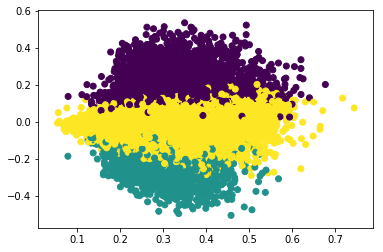

In [66]:
from sklearn.cluster import SpectralClustering

# We know we're looking for three clusters.
n_clusters=3

# Declare and fit the model.
sc = SpectralClustering(n_clusters=n_clusters)
sc.fit(X_train_lsa, X_test_lsa)

#Predicted clusters.
predict=sc.fit_predict(X_train_lsa)

#Graph results.
plt.scatter(X_train_lsa[:, 0], X_train_lsa[:, 1], c=predict)
plt.show()



In [67]:
X_train['labels_sc'] = sc.labels_

C:\Users\Martin\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [68]:
pd.crosstab(X_train['labels_sc'], y_train)

publication_id,0,1,2,3,4,5,6,7,8,9,10
labels_sc,,,,,,,,,,,
0,1071,77,193,117,51,188,17,69,5,139,264
1,449,95,86,127,37,115,192,107,18,48,62
2,5774,477,497,297,485,861,507,666,84,247,757


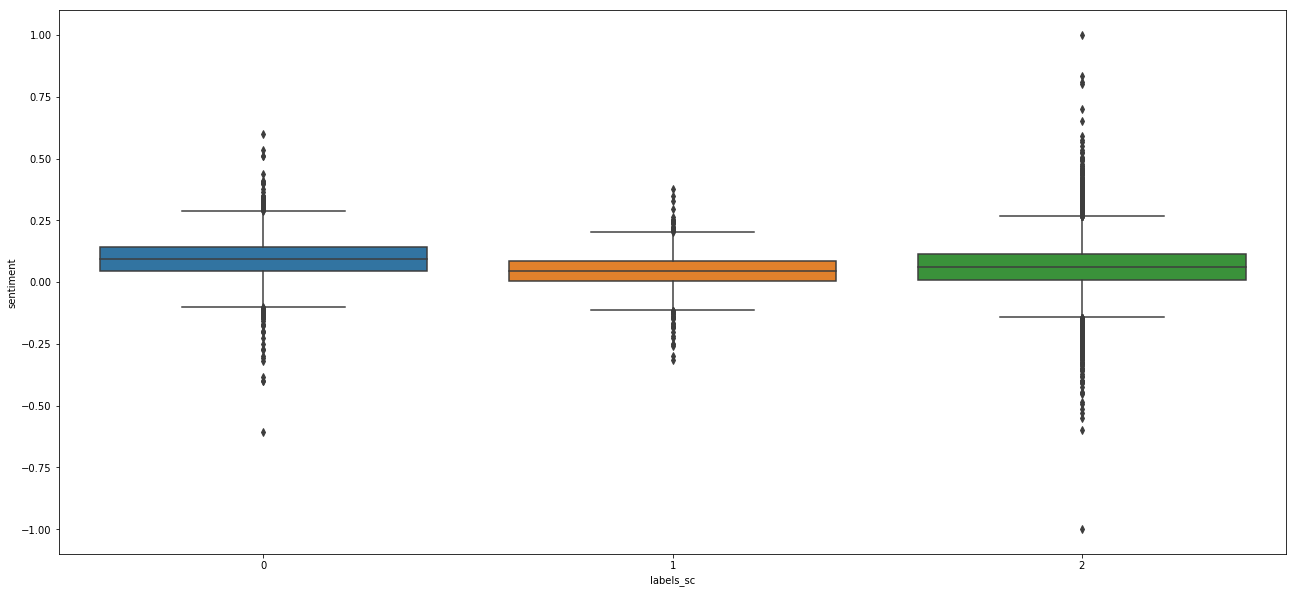

In [149]:
plt.figure(figsize=(22,10))
sns.boxplot(x='labels_sc', y='sentiment', data=X_train, )
plt.show()

In [113]:
df2['publication_id'].value_counts()

0     9694
5     1553
10    1467
7     1136
2     1014
6      957
1      845
4      770
3      740
9      602
8      128
Name: publication_id, dtype: int64

In [112]:
df2['publication'].value_counts()

Breitbart              9694
National Review        1553
Vox                    1467
New York Post          1136
Washington Post        1014
Talking Points Memo     957
CNN                     845
Atlantic                770
Business Insider        740
NPR                     602
Guardian                128
Name: publication, dtype: int64

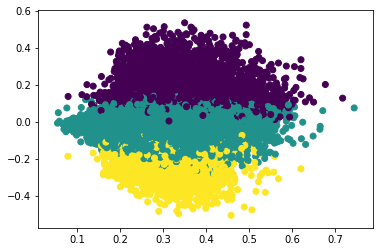

Comparing k-means clusters against the data:


publication_id,0,1,2,3,4,5,6,7,8,9,10
row_0,,,,,,,,,,,
0,1233,103,222,132,87,285,20,100,11,152,336
1,5638,445,461,290,438,742,520,629,78,230,674
2,423,101,93,119,48,137,176,113,18,52,73


In [150]:


# Calculate predicted values.
y_pred = KMeans(n_clusters=3, random_state=42).fit_predict(X_train_lsa)

# Plot the solution.
plt.scatter(X_train_lsa[:, 0], X_train_lsa[:, 1], c=y_pred)
plt.show()

# Check the solution against the data.
print('Comparing k-means clusters against the data:')
pd.crosstab(y_pred, y_train)

In [70]:
model = KMeans(n_clusters=3, random_state=42).fit(X_train_lsa)

In [71]:
labels = model.labels_

In [72]:
model2 = KMeans(n_clusters=3, random_state=42).fit(X_test_lsa)

In [73]:
labels2 = model2.labels_

In [74]:
from sklearn import metrics
from sklearn.metrics import pairwise_distances
print(metrics.silhouette_score(X_train_lsa, labels, metric='euclidean'))
print(metrics.silhouette_score(X_test_lsa, labels2, metric='euclidean'))

0.013561615661907429
0.012066613184717858


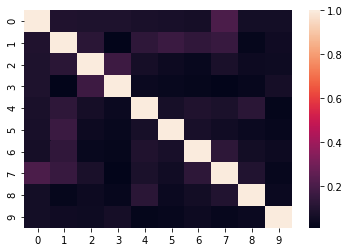

Key:
0 ('survived scare kansas fourth congressional district tuesday night winning deeply conservative district starting look like might slip democratic control last minute ron estes treasurer defeated civil right attorney democrat jim thompson according associated press around 1045 pm estes ahead 8 point outcome radically alter composition power washington right control 238 seat democrat 194 switch obviously wouldnt much loosen majority next week democrat get rematch georgia sixth congressional district democrat jon ossoff raised money better polling almost anyone predicted today win give room breathe little easier democrat crushed donald presidency dreamed theyd begin reversing tide election first congressional race since inauguration instead came short nobody thought race remotely competitive still worth stepping back looking surprising democrat competitive kansa fourth district race opened donald appointed former rep mike pompeo director cia district deeply red long flown far radar

3 ('gop frontrunner donald increasing presence badger ahead tuesday primary adding several campaign event sunday monday friday added two event schedule saturday real estate mogul spending sunday monday wisconsin packed schedule well hold event sunday night fox news greta van susteren three campaign event monday day wisconsinite head poll former alaska gov sarah palin also campaigning cheesehead stumping', 31, 0.15000000000000002, 0)
4 ('line vanquish doubt donald attorney general jeff session want escalate america war drug federal criminal justice system simply broken fact working exactly designed comment come steven cook top lieutenant sessions inner circle often travel attorney general side speaks new administration goal new profile washington post sari horwitz detail cook view war drug making clear sessions closest confidant conservative hardliner criminal justice issue cook former federal prosecutor national association assistant attorney doesnt even appear think federal justice sy

7 ('senator kelly ayotte great moment debate stage asked whether tell child aspire like donald whether moderator put point role model ayotte seemed caught guard question think uh certainly many role model um believe serve absolutely stammered democratic challenger maggie hassan later released ad highlighting remark turn led ayotte campaign release ad ayotte offered there escaping fact terrible role model unless course want child become habitual liar walking conflict interest file false tax information berate aide reflexively defend ridiculing woman made choice label political opponent enemy engaged vast conspiracy demand check university speak hour rising cost higher education get rebuked fbi extremely careless handling sensitive highly classified information tried turn role model shoehorning life traditional narrative adversity overcome ignore epic fumbling reform early bill presidency public sympathy lewinsky scandal new york senate seat delivered 2000 spectacular collapse 2008 democ

In [75]:
# Compute document similarity using LSA components
similarity = np.asarray(np.asmatrix(X_train_lsa) * np.asmatrix(X_train_lsa).T)
#Only taking the first 10 sentences
sim_matrix=pd.DataFrame(similarity,index=X_train).iloc[0:10,0:10]
#Making a plot
ax = sns.heatmap(sim_matrix,yticklabels=range(10))
plt.show()

#Generating a key for the plot.
print('Key:')
for i in range(10):
    print(i,sim_matrix.index[i])


In [76]:
#X = content_vect
#y = df2['author_id']


from sklearn.cluster import KMeans

num_clusters = 5

km = KMeans(n_clusters=num_clusters)

%time km.fit(X_train_lsa)



Wall time: 19.4 s


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [77]:
#clusters = km.labels_.tolist()
#labels = km.predict(X_train_lsa)
X_train['labels_km'] = km.labels_

C:\Users\Martin\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [78]:
X_train.columns

Index(['content', 'author_id', 'sentiment', 'labels_sc', 'labels_km'], dtype='object')

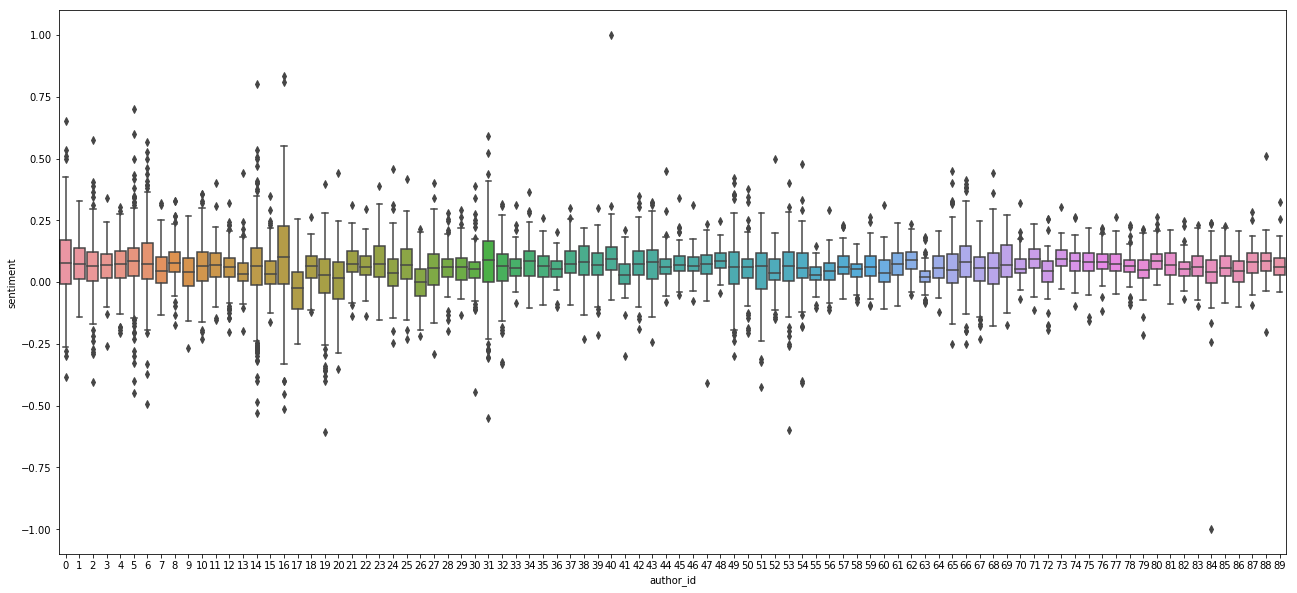

In [79]:
#for i in X_train.columns:
#X_train=X_train.sample(frac=.01)
plt.figure(figsize=(22,10))
sns.boxplot(x='author_id', y='sentiment', data=X_train, )
plt.show()

C:\Users\Martin\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


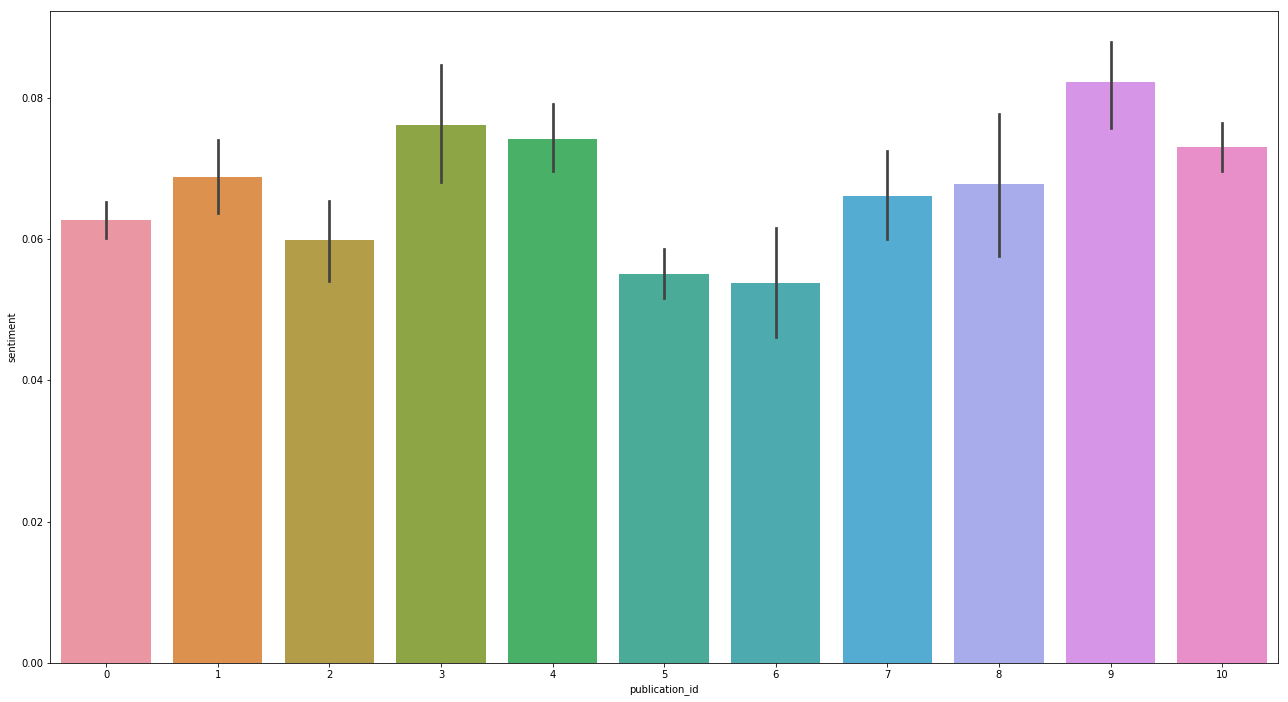

In [80]:
plt.figure(figsize=(22,12))
sns.barplot(x=y, y='sentiment', data=X_train, )
plt.show()

In [81]:
from sklearn import ensemble
from sklearn.model_selection import train_test_split

rfc = ensemble.RandomForestClassifier()
X_train_rfc = X_train_lsa
X_test_rfc = X_test_lsa

train = rfc.fit(X_train_rfc, y_train)

print('Training set score:', rfc.score(X_train_rfc, y_train))
print('\nTest set score:', rfc.score(X_test_rfc, y_test))

C:\Users\Martin\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Training set score: 0.984836730375908

Test set score: 0.48973979268034695


In [115]:
from sklearn import ensemble
from sklearn.model_selection import train_test_split

rfc = ensemble.RandomForestClassifier()
X_train_bow_rfc = X_train_content_bow
X_test_bow_rfc = X_test_content_bow

rfc.fit(X_train_bow_rfc, y_train)
print(rfc.score(X_train_bow_rfc, y_train))
print(rfc.score(X_test_bow_rfc, y_test))


C:\Users\Martin\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9894209746808661
0.4734503913687328


In [116]:
from sklearn import ensemble
from sklearn.model_selection import train_test_split

rfc = ensemble.RandomForestClassifier()


rfc.fit(X_train_lsa, y_train)
print(rfc.score(X_train_lsa, y_train))
print(rfc.score(X_test_lsa, y_test))


C:\Users\Martin\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9866704280978913
0.4912206473450391


For my capstone project I acquired three datasets containing a total of 142,570 news articles from 2016 and 2017.  I chose to narrow these news articles to only those that mentioned the names "Trump" or "Obama", I further narrowed this down to only articles written by authors who had more than one hundred articles included in the corpus, this left me with a corpus 18,906 news articles to process.

I used the Textblob library to lemmatize and tokenize the data, and also to run sentiment anlysis with.  

My corpus consisted of a dataframe with 15 features spread across 18,906 rows of data.  Features I used in my models were: publication (New York Times, Breitbart, etc.), publication_id (integer representing each publication), author, author_id (integer representing each author), and sentiment (an integer ranging from negative one to positive one generated by the Textblob library.

I ran my model using the publication_id feature as my "y" value, with the goal of being able to predict which publication published any particular news article.  I vectorized my data using the sklearn.





